# Project Introduction: Benchmarking Summaries using MediaSUM Dataset

## Scope of the Project
The primary objective of this project is to demonstrate the methodology for benchmarking text summarization models. We utilize the MediaSUM dataset, a rich collection of news interview transcripts, to evaluate the performance of our summarization techniques using ROUGE scores. By the end of this project, you'll understand how to preprocess data, generate summaries, and assess their quality effectively.


## Key Sections of the Notebook
1. Data Preprocessing
2. Text Summarization using BART and GPT-3
3. Performance Evaluation with ROUGE Scores

## Results
We do not make statisticaly significant findings it is for demo purposes only
  
Date: January 2025

In [1]:
from huggingface_hub import login
import openai
import os
import pandas as pd
from rouge_score import rouge_scorer
import timeit
import torch
from transformers import pipeline


In [2]:
# Prepare BART Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
bart_summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum", device_map = device)
print(device)

c:\Users\johnt\.conda\envs\ds\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cuda


In [3]:
print("\nSetting huggingface key...")
with open("../../.secrets/huggingface_token_2501_general_read.txt", 'r') as f:
    huggingface_access_token = f.read()
login(token=huggingface_access_token)


print("\nSetting openai key...")
with open("../../.secrets/2501-openai-rwx-key.key", 'r') as f:
    openai.api_key = f.read()
    os.environ["OPENAI_API_KEY"] = openai.api_key
    print("Key length: ", len(os.environ["OPENAI_API_KEY"]))



Setting huggingface key...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\johnt\.cache\huggingface\token
Login successful

Setting openai key...
Key length:  164


In [4]:
def clean_bart_summary_chunk(inference_model, text, max_tokens = 1000, min_tokens = 164, verbose = False):
    """

    NOT WORKING

    Roughly clean and Summarize text using inferance model in chunks to ensure that text within token limit.

    Parameters:
        inference_model : object
            Summarization model instance.
            e.g. bart_summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
        text : str
            Input text to summarize.
        max_tokens : int, optional, default=1000
            Max token limit per chunk, estimated as 1 token = 4 characters.

    Returns:
        str
            Summarized text. Will be a concatenation of summaries for very long texts.
    """
    chunked_text = [text[i:i+max_tokens*4] for i in range(0, len(text), max_tokens*4)]
    summaries = []
    os.environ["TORCH_USE_CUDA_DSA"] = "1"
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    with torch.no_grad():
        torch.cuda.empty_cache()
    
    # Split text into chunks of max_tokens*4 characters
    if verbose: 
        print(f"\nText of length {len(text)} split into {len(chunked_text)} chunks.")

    if len(text) < min_tokens*4:
        if verbose:
            print( f"Text of length {len(text)} is too short to summarize.")
        return text

    for chunk in chunked_text:
        if len(chunk) > min_tokens*4:
            try:
                summaries.append( inference_model(chunk)[0]["summary_text"])
            except Warning as w:
                pass
        else:
            summaries.append(chunk)
    

    # Join summaries and check if the combined length is within max_tokens4 limit

    combined_summary = "\n".join(summaries)
    if len(combined_summary) < max_tokens*4:
        return combined_summary
    if verbose:
        print( f"Text of length {len(text)} condensed to {len(combined_summary)} characters.")
    
    if len(summaries) == 0:
        return text
    elif len(summaries) == 1:
        return summaries[0]
    else:
        try:
            return inference_model(" ".join(summaries))[0]["summary_text"]
        except RuntimeError as e:
            return str(e)
        except Warning as w:
            pass
    

def clean_bart_summary_clip(inference_model, text, max_tokens = 1000):
    ''' Roughly clean input text for bart using token estimation of 1 token = 4 characters '''
    # split input txt into chunks of max_tokens4 characters
    clipped_text = text[:max_tokens*4] 
    if len(clipped_text) < len(text):
        print("Dropped ",  len(text) - len(clipped_text), " characters.")
    
    return inference_model(clipped_text)[0]["summary_text"]   


In [5]:
def get_template_completion(catalogue_item_name: str, prompt_catalogue: pd.DataFrame, input_text: str,
                   model_name: str ="gpt-3.5-turbo", temperature: float = 0.25, verbose=False  ) -> str:
    """
    Generates a completion using OpenAI's ChatCompletion API based on the provided prompt configuration and input text.

    Args:
        prompt_config (dict): A dictionary containing the prompt configuration with keys such as 'unique_name', 'task_category', 'system_prompt', etc.
        input_text (str): The text to be summarized.

    Returns:
        str: The assistant's response (completion).

    Raises:
        Exception: If an error occurs during the OpenAI API call.
    """
    try:
        prompt_context = prompt_catalogue[prompt_catalogue["unique_name"] == catalogue_item_name].iloc[0].to_dict()
    except IndexError:
        raise ValueError(f"Unique name '{unique_name}' not found in the catalogue.")
    
    # Extract the system prompt from the prompt configuration
    system_prompt = prompt_context.get('system_prompt', 'You are a helpful chatbot.')
    user_prompt_example = prompt_context.get('user_prompt_example')
    assistant_response_example = prompt_context.get('assistant_response_example')
    user_message = input_text
    
    # Prepare the messages for the API call
    messages = [{"role": "system", "content": system_prompt}]
    # Optionally, you can provide an example user message and assistant response 
    if  user_prompt_example and assistant_response_example:
        messages.append( {"role": "user", "content": user_prompt_example} )
        messages.append( {"role": "assistant", "content": assistant_response_example} )
    messages.append({"role": "user", "content": user_message})

    if verbose:
        print(messages)
    
    client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    
    try:
        response = client.chat.completions.create(
            messages=messages,
            model=model_name,
            temperature=temperature,    # You can adjust the temperature for creativity (0.7-1) or factual (0-0.5)
        )
        # Extract the assistant's reply
        return response.choices[0].message.content
         
    except openai.OpenAIError as e:
        raise Exception(f"OpenAI API error: {str(e)}")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {str(e)}")


# Read in MediaSUM data 

***MediaSUM Data Overview**
MediaSum, a large-scale media interview dataset consisting of 463.6K transcripts with abstractive summaries. 
- CNN interviews use the Title as a one sentence summary
- NPR provides human writen abstractive, 2-4 sentence summaries 

**Additional Processing:**
- Applied categorical labels to CNN data based on program (e.g. CNN's "Your money" = "busniness")
-  In this analysis we will use a  a smaller ~4k row dataset 


| Column Name                   | Datatype | Description                                                  |
|-------------------------------|----------|--------------------------------------------------------------|
| id                            | int      | Unique identifier for each record                            |
| program_name                  | str      | Name of the program                                          |
| air_date                      | int      | Air date of the program (timestamp)                          |
| transcript_url                | str      | URL link to the transcript                                   |
| title                         | str      | Title of the transcript                                      |
| human_summary                 | str      | Human-generated summary for NPR, Title or tags for CNN       |
| transcript_list               | list(str)| List of transcript segments                                  |
| speaker_list                  | list(str)| List of speakers corresponding to transcript segments        |
| news_agency                   | str      | News agency responsible for the program                      |
| program_category              | str      | Category of the program                                      |
| flat_transcript               | str      | Full transcript as a single string                           |
| transcript_length             | int      | Length of the transcript (number of characters)              |
| transcript_speaker_tuples     | list(toup)| List of tuples (speaker, transcript)                        |
| flat_transcript_speaker       | str      | Formatted flat transcript with speaker labels                |

Paper: [https://arxiv.org/abs/2103.06410]  - Chenguang Zhu et. all  
Data: [https://github.com/zcgzcgzcg1/MediaSum/]

news_agency
CNN    Axes(0.125,0.11;0.775x0.77)
NPR    Axes(0.125,0.11;0.775x0.77)
Name: transcript_length, dtype: object

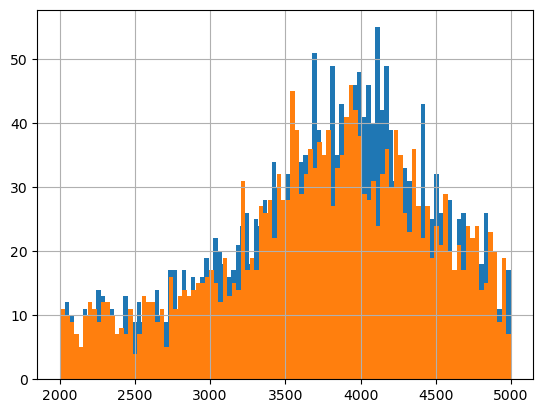

In [6]:
df = pd.read_json("MediaSUM_Short_Tiny_Oversampled.zip", compression="zip", lines=True)
df["transcript_length"].groupby(df["news_agency"]).hist(bins=100)

In [34]:
df.groupby("news_agency").describe()
# Most transcripts will be within our token limit of about 4000 characters (1024 tokens) for bart

transcript_length                                            \
                        count         mean         std     min      25%   
news_agency                                                               
CNN                    2320.0  3749.790086  690.567234  2002.0  3319.75   
NPR                    2108.0  3733.356736  713.347232  2007.0  3303.00   

                                      
                50%      75%     max  
news_agency                           
CNN          3827.0  4249.25  4997.0  
NPR          3801.5  4258.50  4999.0

In [8]:
sm = df[(df["transcript_length"] > 1000) & (df["transcript_length"] < 6000)].sample(10) # smaller df


#### Summarization Techniques

**Bart**  
[https://huggingface.co/philschmid/bart-large-cnn-samsum]

**OpenAI - GTP-3**  
[https://platform.openai.com/]

**Expected Performance**  
[https://arxiv.org/pdf/2103.06410]

These inferance models will add the columns:
| Column Name                   | Datatype | Description                                                  |
|-------------------------------|----------|--------------------------------------------------------------|
| bart-large-cnn-samsum-summary | str      | Summary generated by the BART model                          |
| gtp_basic_instruct_summary    | str      | Summary generated by the GPT basic instruction model         |
| gtp_coreference_summary       | str      | Summary generated by the GPT coreference model               |


#### Get Bart Summaries

In [9]:
sm["bart-large-cnn-samsum-summary"] = sm.flat_transcript.apply( lambda s : clean_bart_summary_chunk(bart_summarizer, s) )

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\johnt\.conda\envs\ds\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johnt\.conda\envs\ds\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\johnt\.conda\envs\ds\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\johnt\.conda\envs\ds\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\johnt\.conda\envs\ds\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\johnt\.conda\envs\ds\

In [10]:
#Example
sm["bart-large-cnn-samsum-summary"].iloc[1]

'Angelica Jade Bastien is a staff writer for Vulture. She liked the new superhero movie "Justice League" and "Mudbound" very much. She also liked another movie with Oscar buzz, "The Artist" which is about a family in the Mississippi Delta in the 1940s.'

In [11]:
with torch.no_grad():
    torch.cuda.empty_cache()

#### Get GPT Summaries

In [12]:
prompt_catalogue = pd.read_excel("openai-api-prompts.xlsx", sheet_name="one-shot")
prompt_catalogue.head()

,unique_name,task_category,system_prompt,user_prompt_example,assistant_response_example
0,summarize_contextual_coreference,summarization,You are a helpful assistant that summarizes te...,Jeff: Can I train a Transformers model on Amaz...,Jeff wants to train a Transformers model on Am...
1,summarize_basic_instruction,summarization,Summarize the given dialogue text in two to th...,"If you or someone you know is out of a job, th...",Etiquette expert Peter Post advises people to ...
2,summarize_coreference,summarization,You are bot that summarizes text using a co-re...,"If you or someone you know is out of a job, th...",Career coach Ellen Gordon Reeves wants you to ...


In [13]:
sm["gtp_basic_instruct_summary"] = sm.flat_transcript.apply(lambda s : get_template_completion("summarize_basic_instruction", prompt_catalogue, s) )

In [15]:
sm["gtp_coreference_summary"] = sm.flat_transcript.apply(lambda s : get_template_completion("summarize_coreference", prompt_catalogue, s) )

#### Compare the summaries  
ROUGE-N — measures unigram, bigram, trigram and higher order n-gram overlap  
ROUGE-L — measures longest matching sequence of words using LCS. An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.  
ROUGE-S — Is any pair of words in a sentence in order, allowing for arbitrary gaps. This can also be called skip-gram concurrence  

**State of the Art**   
Rouge ~0.45  
F1 ~0.79   

Source: 

**How can you Interpret the ROUGE Scores?**  
ROUGE scores can vary depending on the type of text and the specific metric being used. Here’s how to interpret these scores:  

*High Precision but Low Recall*: This indicates that the candidate text includes accurate information but may have omitted some crucial details from the reference text. This might happen in cases where the summary is too concise.   

*Low Precision but High Recall*: This suggests that the candidate text captures most of the reference text’s content but includes additional, possibly irrelevant, information. This might occur if the summary is too lengthy.  

*Balanced Precision and Recall (High F1-Score)*: A high F1-score indicates that the candidate text balances relevance and completeness well. This is often the desired outcome, especially in summarisation tasks where coverage and conciseness are essential.  .4 is considered very good.

**Sources**  
USB: A Unified Summarization Benchmark Across Tasks and Domains [https://arxiv.org/abs/2305.14296]    
[https://www.freecodecamp.org/news/what-is-rouge-and-how-it-works-for-evaluation-of-summaries-e059fb8ac840/]  
[https://spotintelligence.com/2024/08/12/rouge-metric-in-nlp/]  

In [17]:
pd.set_option('display.max_colwidth', 500) 
sm.head(1)

,id,program_name,air_date,transcript_url,title,human_summary,transcript_list,speaker_list,news_agency,program_category,flat_transcript,transcript_length,transcript_speaker_tuples,flat_transcript_speaker,bart-large-cnn-samsum-summary,gtp_basic_instruct_summary,gtp_coreference_summary
3920,NPR-32133,morning edition,1265587200000,https://www.npr.org/templates/story/story.php?storyId=123485271,Japan Braces For More Recalls From Toyota,"The Japanese press report Toyota is considering even more recalls. This time the recalls would involve 2010 Prius and the Lexus and Sai hybrids — they all share the same brake glitch. The recalls could be announced as early as Tuesday. For decades, Toyota has been one of the main drivers of the Japanese economy but its reputation has been sullied.","[Its MORNING EDITION from NPR News. Good morning. Im Renee Montagne., And Im Steve Inskeep., Toyota is preparing for what may be another week of recalls. This is the week the giant automaker is expected to answer complaints about braking systems on popular cars., The New York Times and the Reuters news service say the company is planning to recall hundreds of thousands of hybrid cars. The recall could include the 2010 Prius., Theres also a Lexus hybrid., And a third hybrid, recently marketed...","[RENEE MONTAGNE, host, STEVE INSKEEP, host, STEVE INSKEEP, host, RENEE MONTAGNE, host, STEVE INSKEEP, host, RENEE MONTAGNE, host, STEVE INSKEEP, host, STEVE INSKEEP, host, LOUISA LIM, Mr. SUICHI MASAMOTO, LOUISA LIM, Mr. TATSUYA MIZUNO (President, Mizuno Credit Advisory), LOUISA LIM, Mr. TATSUYA MIZUNO (President, Mizuno Credit Advisory), LOUISA LIM, Professor KENNETH GROSSBERG (Waseda University), LOUISA LIM, Professor KENNETH GROSSBERG (Waseda University), LOUISA LIM, LOUISA LIM]",NPR,null,"Its MORNING EDITION from NPR News. Good morning. Im Renee Montagne.\n And Im Steve Inskeep.\n Toyota is preparing for what may be another week of recalls. This is the week the giant automaker is expected to answer complaints about braking systems on popular cars.\n The New York Times and the Reuters news service say the company is planning to recall hundreds of thousands of hybrid cars. The recall could include the 2010 Prius.\n Theres also a Lexus hybrid.\n And a third hybrid, recently...",4277,"[[RENEE MONTAGNE, host, Its MORNING EDITION from NPR News. Good morning. Im Renee Montagne.], [STEVE INSKEEP, host, And Im Steve Inskeep.], [STEVE INSKEEP, host, Toyota is preparing for what may be another week of recalls. This is the week the giant automaker is expected to answer complaints about braking systems on popular cars.], [RENEE MONTAGNE, host, The New York Times and the Reuters news service say the company is planning to recall hundreds of thousands of hybrid cars. The recall coul...","RENEE MONTAGNE, host: Its MORNING EDITION from NPR News. Good morning. Im Renee Montagne.\nSTEVE INSKEEP, host: And Im Steve Inskeep.\nSTEVE INSKEEP, host: Toyota is preparing for what may be another week of recalls. This is the week the giant automaker is expected to answer complaints about braking systems on popular cars.\nRENEE MONTAGNE, host: The New York Times and the Reuters news service say the company is planning to recall hundreds of thousands of hybrid cars. The recall could includ...","This morning on NPR News, Renee Montagne, Steve Inskeep and Louisa Lim report on the possible recall of hundreds of thousands of hybrid cars by Toyota. In Japan, Toyota is bracing itself for another week of recalls. The company has already recalled 8 million cars for other defects, including the 2010 Prius.\neen criticized here, with the press turning on CEO Akio Toyoda for an apology which was seen as insincere. Most are desperately hoping that Toyota is learning from its mistakes. For the ...","Toyota is expected to recall hundreds of thousands of hybrid cars, including the 2010 Prius, due to braking system complaints. The recalls have had a significant impact on Toyota City, affecting tax reven

In [35]:

# Initialize the ROUGE scorer
rouge_1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

# Apply the scorer to each row and expand the results into new columns

summary_cols = ["bart-large-cnn-samsum-summary", "gtp_basic_instruct_summary", "gtp_coreference_summary"]
nick_names = ["bart", "gtp_basic", "gtp_coreference"]

sm[['bart_rouge1_precision', 'bart_rouge1_recall', 'bart_rouge1_f']] = sm.apply(
    lambda row: pd.Series(rouge_1.score(row['human_summary'], row['bart-large-cnn-samsum-summary'])['rouge1']),
    axis=1
)

sm[['gtp_basic_rouge1_precision', 'gtp_basic_rouge1_recall', 'gtp_basic_rouge1_f']] = sm.apply(
    lambda row: pd.Series(rouge_1.score(row['human_summary'], row['gtp_basic_instruct_summary'])['rouge1']),
    axis=1
)

sm[['gtp_coreference_rouge1_precision', 'gtp_coreference_rouge1_recall', 'gtp_coreference_rouge1_f']] = sm.apply(
    lambda row: pd.Series(rouge_1.score(row['human_summary'], row['gtp_coreference_summary'])['rouge1']),
    axis=1
)





In [36]:
sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transcript_length,10.0,3372.700000,724.261931,2608.0,2773.250000,3242.000000,3769.250000,4712.000000
bart_rouge1_precision,10.0,0.153136,0.184050,0.0,0.003623,0.070960,0.265152,0.520000
bart_rouge1_recall,10.0,0.222316,0.230350,0.0,0.011364,0.147436,0.427586,0.553191
bart_rouge1_f,10.0,0.171656,0.194136,0.0,0.005495,0.083198,0.326642,0.536082
gtp_basic_rouge1_precision,10.0,0.143539,0.164043,0.0,0.018426,0.044071,0.280542,0.412698
gtp_basic_rouge1_recall,10.0,0.237970,0.210947,0.0,0.100233,0.174242,0.398276,0.638298
gtp_basic_rouge1_f,10.0,0.168669,0.182741,0.0,0.031960,0.064489,0.309387,0.458015
gtp_coreference_rouge1_precision,10.0,0.099618,0.107617,0.0,0.015708,0.038741,0.210915,0.254386
gtp_coreference_rouge1_recall,10.0,0.312196,0.232610,0.0,0.130245,0.257576,0.495833,0.657895
gtp_coreference_rouge1_f,10.0,0.142713,0.146611,0.0,0.027551,0.057377,0.294824,0.345679


#### Precision
- Measures how many of the words in the candidate summary are also in the reference summary (higher is better)
- Focuses on how much of the candidate text is relevant or correct. 
- Indicates that most of the content in the candidate text is also found in the reference text, meaning the model did not introduce much irrelevant information.

$$\text{Precision} = \frac{\text{Number of Overlapping Words}}{\text{Total Words in Summary}}$$

<Axes: >

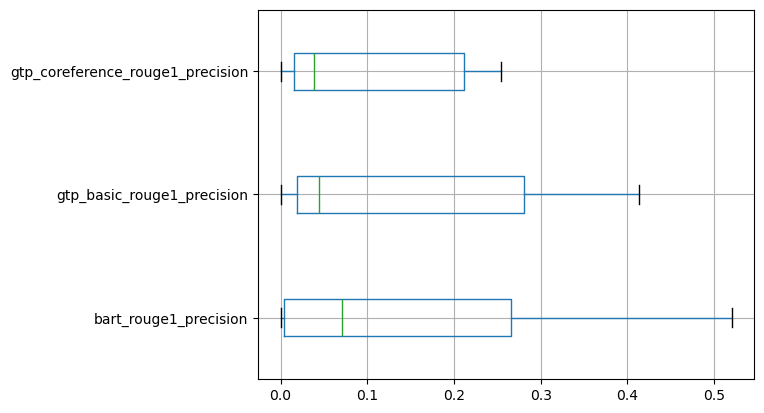

In [37]:
sm[["bart_rouge1_precision", "gtp_basic_rouge1_precision", "gtp_coreference_rouge1_precision"]].boxplot(vert=False)


#### Recall
-  Measures how many of the words in the reference summary are captured by the candidate summary. 
 $$\text{Recall} = \frac{\text{Number of overlapping words in candidate and reference}}{\text{Number of words in reference}}$$

<Axes: >

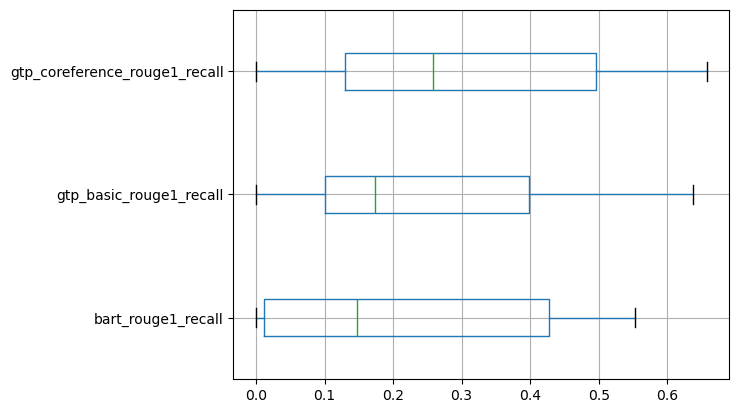

In [38]:
sm[["bart_rouge1_recall", "gtp_basic_rouge1_recall", "gtp_coreference_rouge1_recall"]].boxplot(vert=False)


#### F-Measure
 The harmonic mean of precision and recall, providing a single score that balances both metrics. 
  $$\text{F-Measure} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

  ### 0.4 is considered very good

<Axes: >

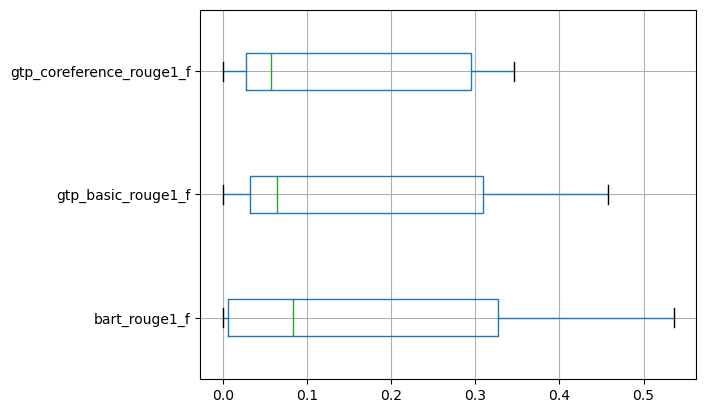

In [39]:
sm[["bart_rouge1_f", "gtp_basic_rouge1_f", "gtp_coreference_rouge1_f"]].boxplot(vert=False)